# Simple example notebook 
1. generate an instance of SK model
2. Load a sk-1rsb autoregressive architecture
3. Train its parameters on the Boltzmann distribution of the SK model

In [2]:
import networkx as nx
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random
#torch.set_num_threads(1)

import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers

from python_lib.nets import h2arnn
from python_lib import run_lib

In [3]:
%matplotlib inline

# Sherrington Kirkpatrick

In [4]:
coupl = "couplings_3D_EA"
pairs = "pairs"
coupl_val = np.array(np.genfromtxt(coupl, delimiter=','), dtype=np.float_)
pairs_val = np.array(np.genfromtxt(pairs, delimiter=' '), dtype=np.int_)

In [5]:
N = int(np.max(pairs_val) + 1)
N

125

In [7]:
len(coupl_val)

375

In [15]:
with open("3dEA.sg", "w") as f:
    f.write(f"{N} {len(coupl_val)}\n")
    for i in range(len(coupl_val)):
        f.write(f"{pairs_val[i, 0]+1} {pairs_val[i, 1]+1} {coupl_val[i]} \n")

In [13]:
for i in range(len(coupl_val)):
    print(pairs_val[i][0]+1, pairs_val[i][1], coupl_val[i])

0 1 1.4779439440382445
0 5 1.8885805188131966
0 25 0.357271011175296
1 2 0.12509066335953956
1 6 1.1693578088215932
1 26 0.10818676339605955
2 3 -0.48780520130081517
2 7 0.7213828104925369
2 27 -0.06312840597575149
3 4 -0.25345759019364067
3 8 -1.4328631914614316
3 28 -0.5992041746617989
4 0 1.2268670259506453
4 9 0.7774611103408576
4 29 -0.1905249411055841
5 6 1.8386671136236483
5 10 -1.1335539548391647
5 30 -0.9996083134119599
6 7 -1.3091350781758093
6 11 2.5476234298244287
6 31 1.0462883808451804
7 8 0.9882061728531906
7 12 -0.43701656009236234
7 32 -2.1072415860644007
8 9 -0.757028757322367
8 13 -1.0249614569859566
8 33 0.12787811665856796
9 5 -1.536334051182588
9 14 -0.9350800009887716
9 34 0.6896773729408341
10 11 0.6594924027302306
10 15 0.40295759283035565
10 35 4.482620311165957
11 12 -0.5816549007001823
11 16 -0.7647060728098298
11 36 -1.15473205305664
12 13 -1.3005676468439666
12 17 1.230923068553239
12 37 0.43122988461525813
13 14 0.8359104093050904
13 18 -0.924061832309792

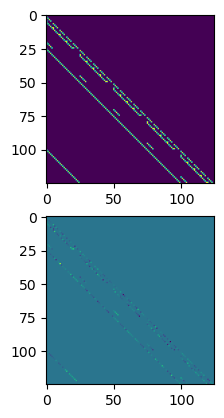

In [6]:
seed=0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

fig, ax0 = plt.subplots(2,1)
J_interaction = torch.zeros(N,N)
J = torch.zeros(N,N)
inter_H = 0
H = inter_H * (torch.ones(N))

ii = 0
for (i,j) in pairs_val:
    #J_interaction[int(j)][int(i)] = 1
    if i > j:
        J_interaction[int(i)][int(j)] = 1
        J[int(i)][int(j)] = coupl_val[ii]
    else:
        J_interaction[int(j)][int(i)] = 1
        J[int(j)][int(i)] = coupl_val[ii]
    ii+=1
ax0[0].imshow(J_interaction)
ax0[1].imshow(J)

# Exact solutions
enumerating all configurations.
Th. results

In [7]:
from python_lib.models import spins_model

device="cpu"
SK_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=4
beta_init = 0.1
step = 79
betas = np.linspace(beta_init, beta_fin, step)

stats_step=1

In [8]:
from python_lib.models import spins_model


SK_model_exact = spins_model.model(N, H, J, J_interaction, device=device)
f_exact = []
f_exact_infN = []
steps = 0
if N < 25:
    for beta_ in betas:
        if steps % stats_step == 0:
            f_exact.append(SK_model_exact.exact(beta_))
        steps += 1
else:
    print("sorry systems too bog for exact computation")


sorry systems too bog for exact computation


# Train net

In [9]:
lr = 0.001
max_step = 1000
batch_size = 2000
std_fe_limit=1e-4
batch_iter=20
stats_step=1

In [10]:
rho = h2arnn.SK_krsb
learn_first_layer = False
dict_nets = {"k": 1, "set_exact": False}
input_mask = torch.tril(torch.ones(N,N, device=device) - torch.eye(N, N, device=device), diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
net = h2arnn.h2arnn(
    SK_model, rho, input_mask, device=device, dict_nets=dict_nets, learn_first_l=learn_first_layer)

Total Trainable Params: 77750
Total Params: 77750


In [11]:
stats = run_lib.train_net(net,
                    betas,
                    lr=lr,
                    max_step=max_step,
                    batch_size=batch_size,
                    std_fe_limit=std_fe_limit,
                    batch_iter=batch_iter,
                    stats_step=stats_step,
                    )

step: 444 2.00000 fe: -1.759 +- 0.00045 E: -1.738, S: 0.042, M: 0.0337 sample_t : 0.42 log_prob : 0.28 loss : 0.00032 optimizer : 0.26 stats : 0.0123123

In [ ]:
stats.to_csv("stats_3dEA.zip")

In [ ]:
torch.save(net, "net_3dEA.zip")